<a href="https://colab.research.google.com/github/ivangonquir/NLP_BSC/blob/main/bsc_internship_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [ ]:
!pip show tensorflow keras tensorflow-hub

In [ ]:


'''
sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]


tokenizer = Tokenizer(num_words = 100, oov_token = "<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding = 'post', truncating = 'post', maxlen = 9)


test_data = [
    'I really love my dog',
    'My dog loves my manatee'
]
test_sequences = tokenizer.texts_to_sequences(test_data)

train, test = tfds.load(name = 'yelp_polarity_reviews',
                        split = (tfds.Split.TRAIN,
                                 tfds.Split.TEST),
                        as_supervised = True
)



pretrained_model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(pretrained_model, input_shape = [], dtype = tf.string, trainable = True)


model = tf.keras.Sequential()

model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) #We want to assign a probability between 0 (bad review) and 1 (good review)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model.fit(train.shuffle(10000).batch(512),
          epochs = 10,
          verbose = 1)


model.predict(["The food is super good but the ambience is excellent, rather it exceeds expectations. The serving time is great"])

model.predict(["The food was tasty and well presented, but we had to wait a lot of time in order to start our dinner. All in all, it was not a good experience."])


# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))

        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask

        # Computing the weights by a softmax operation
        weights = softmax(scores)

        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)

# Implementing the Multi-Head Attention
class MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        self.W_q = Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = Dense(d_v)  # Learned projection matrix for the values
        self.W_o = Dense(d_model)  # Learned projection matrix for the multi-head output

    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = tf.reshape(x, shape=(x.shape[0], x.shape[1], heads, -1))
            x = tf.transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = tf.transpose(x, perm=(0, 2, 1, 3))
            x = tf.reshape(x, shape=(x.shape[0], x.shape[1], self.d_k))
        return x

    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)


h = 8 # Number of self-attention heads
d_k = 64 # Dimensionality of the linearly projected queries and keys
d_v = 64 # Dimensionality of the linearly projected values
d_model = 512 # Dimensionality of the model sub-layers' outputs
batch_size = 64 # Batch size from the training proces
input_seq_length = 5 # Maximum length of the input sequence

queries = np.random.random((batch_size, input_seq_length, d_k))
keys = np.random.random((batch_size, input_seq_length, d_k))
values = np.random.random((batch_size, input_seq_length, d_v))

multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)


sentence = "Life is short, eat dessert first"
dc = {s:i for i,s in enumerate(sorted(sentence.replace(',','').split()))} #Capital letters go first
sentence_int = torch.tensor(
    [dc[s] for s in sentence.replace(',', '').split()]
)

multihead_attention(queries, keys, values)


vocab_size = 50_000

torch.manual_seed(123) #For reproducibility
embed = torch.nn.Embedding(vocab_size, 3)
embedded_sentence = embed(sentence_int).detach()
embedded_sentence


d_q, d_k, d_v = 2,2,4
W_query = torch.nn.Parameter(torch.rand(d, d_q))
W_key = torch.nn.Parameter(torch.rand(d, d_k))
W_value = torch.nn.Parameter(torch.rand(d,d_v))

x_2 = embedded_sentence[1]

print(x_2)
print(x_2.shape)

query_2 = x_2 @ W_query # 1x3 x 3x2 = 1x2
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

keys = embedded_sentence @ W_key
values = embedded_sentence @ W_value

omega_24 = query_2.dot(keys[4])

omega_2 = query_2 @ keys.T
omega_24, omega_2

attention_weights_2 = F.softmax(omega_2 / d_k**0.5, dim = 0)
attention_weights_2

context_vector_2 = attention_weights_2 @ values
context_vector_2

class SelfAttention(nn.Module):

  def __init__(self, d_in, d_out_kq, d_out_v):
    super().__init__()
    self.d_out_kq = d_out_kq
    self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
    self.W_key = nn.Parameter(torch.rand(d_in, d_out_kq))
    self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))

  def forward(self, x):
    keys = x @ self.W_key
    queries = x @ self.W_query
    values = x @ self.W_value

    attn_scores = queries @ keys.T #unnormalized attention weights
    attn_weights = torch.softmax(
        attn_scores / self.d_out_kq**0.5, dim = -1
    )

    context_vec = attn_weights @ values
    return context_vec


torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3,2,4

sa = SelfAttention(d_in, d_out_kq, d_out_v)

sa(embedded_sentence)



v1 = torch.tensor([[1,2,3], [-1,2,0]])
v2 = torch.tensor([[4,5,6], [3,-2,1]])
for j in range(-1,2):
  print(torch.cat([v1, v2], dim = j))


W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
W_query

embedded_sentence[0]

embedded_sentence[0] @ W_query

W_query.T @ embedded_sentence[0]


class MultiHeadAttentionWrapper(nn.Module):

  def __init__(self, d_in, d_out_kq, d_out_v, num_heads):
    super().__init__()
    self.heads = nn.ModuleList(
        [SelfAttention(d_in, d_out_kq, d_out_v)
        for _ in range(num_heads)]
    )

  def forward(self, x):
    return torch.cat([head(x) for head in self.heads], dim = -1)


# 1 head

torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3,2,1

sa = SelfAttention(d_in, d_out_kq, d_out_v)
print(sa(embedded_sentence))


# 4 attention heads

torch.manual_seed(123)

block_size = embedded_sentence.shape[1]
mha = MultiHeadAttentionWrapper(
    d_in, d_out_kq, d_out_v, num_heads = 4
)

context_vecs = mha(embedded_sentence)

print(context_vecs)  #6x4 -> 6 input tokens and 4 self-attention heads

'''
We see that before we also had an output of dimension 6x4 by choosing
`d_out_v` = 4. However, in MultiHeadAttention, each attention head can learn
to focus on different parts of the input sequence, capturing various aspects
or relationships within the data. It can also be more efficient in terms of
 parallel computing, since each head can be processed independently. In short,
  multiple attention heads allow us to increase the model capacity, learn a
   diverse set of features and relationships within the data.
'''

embedded_sentence.shape[1]


class CrossAttention(nn.Module):

  def __init__(self, d_in, d_out_kq, d_out_v):
    super().__init__()
    self.d_out_kq = d_out_kq
    self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
    self.W_key = nn.Parameter(torch.rand(d_in, d_out_kq))
    self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))

  def forward(self, x_1, x_2): # x_2 is new
    queries_1 = x_1 @ self.W_query

    keys_2 = x_2 @ self.W_key
    values_2 = x_2 @ self.W_value

    attn_scores = queries_1 @ keys_2.T
    attn_weights = torch.softmax(
        attn_scores / self.d_out_kq**0.5, dim = -1
        )

    context_vec = attn_weights @ values_2

    return context_vec


torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

crossattn = CrossAttention(d_in, d_out_kq, d_out_v)

first_input = embedded_sentence
second_input = torch.rand(8, d_in)  #They don't have to have the same number of tokens
                                    #but the dimension embedding must be the same

print("First input shape:", first_input.shape)
print("Second input shape:", second_input.shape)


context_vectors = crossattn(first_input, second_input)
print(context_vectors)
print(context_vectors.shape)


'''
Cross attention is useful when we want to translate one input sentence
 into an output sentence, since sometimes we can't translate word by word in
 the same order and thus we need more information on the sourroundings of the word.
'''

'''


"""
PROCESS = INPUT EMBEDDING + ENCODER
  ENCODER = POSITIONAL ENCODING + MULTI-HEAD ATTENTION + ADD & NORM + FEED FORWARD + ADD & NORM.


  x = ["How are you?",
        "I'm fine, thanks"

2. POSITIONAL ENCODING: We provide information to the input embeddings to provide information about the position of each
  token in the sequence.
x = How are you?
"""
class MultiHeadAttention(nn.Module):
	def __init__(self, d_model, num_heads, p, d_input = None):
		super().__init__()
		self.num_heads = num_heads
		self.d_model = d_model
		if d_input is None:
			d_xq = d_xk = d_xv = d_model
		else:
			# if d_input is provided, it becomes cross attention, otherwise its self-attention
			d_xq, d_xk, d_xv = d_input

		assert d_model % self.num_heads == 0
		self.d_k = d_model // self.num_heads

		self.W_q = nn.Linear(d_xq, d_model, bias = False)
		self.W_k = nn.Linear(d_xk, d_model, bias = False)
		self.W_v = nn.Linear(d_xv, d_model, bias = False)
		self.W_h = nn.Linear(d_model, d_model)

	def scaled_dot_product_attention(self, Q, K, V):
		batch_size = Q.size(0)
		k_length = K.size(-2)

		Q = Q/np.sqrt(self.d_k)
		scores = torch.matmul(Q, K.transpose(2,3))

		A = nn_Softargmax(dim = -1)(scores)

		H = torch.matmul(A,V)

		return H, A

	def split_heads(self, x, batch_size):
		return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1,2)

	def group_heads(self, x, batch_size):
		return x.transpose(1,2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)

	def forward(self, X_q, X_k, X_v):
		batch_size, seq_length, dim = X_q.size()

		Q = self.split_heads(self.W_q(X_q), batch_size)
		K = self.split_heads(self.W_k(X_k), batch_size)
		V = self.split_heads(self.W_v(X_v), batch_size)

		H_cat, A = self.scaled_dot_product_attention(Q,K,V)
		H_cat = self.group_heads(H_cat, batch_size)
		H = self.W_h(H_cat)

		return H,A



class EncoderLayer(nn.Module):
	def __init__(self, d_model, num_heads, conv_hidden_dim, p = 0.1):
		self.mha = MultiHeadAttention(d_model, num_heads, p)
		self.layernorm1 = nn.LayerNorm(normalized_shape = d_model, eps = 1e-6)
		self.layernorm2 = nn.LayerNorm(normalized_shape = d_model, eps = 1e-6)

	def forward(self, x):
		attn_output, _ = self.mha(x,x,x)
		out1 = self.layernorm1(x + attn_output)
		cnn_output = self.cnn(out1)
		out2 = self.layernorm2(out1 + cnn_output)
		return out2


class Encoder(nn.Module):
	def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim, input_vocab_size, maximum_position_encoding, p = 0.1):
		self.embedding = Embeddings(d_model, input_vocab_size, maximum_position_encoding, p)
		self.enc_layers = nn.ModuleList()
		for _ in range(num_layers):
			self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim, p))

		def forward(self, x):
			x = self.embedding(x)
			for i in range(self.num_layers):
				x = self.enc_layers[i](x)

			return x

class TransformerClassifier(nn.Module):
  def __init__(self, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
    super().__init__()

  def forward(self, x):
    x = Encoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers)(x)
    x = nn.Linear(d_model, num_answers)(x)
    return torch.max(x, dim = 1)

model = TransformerClassifier(num_layers = 1, d_model = 32, num_heads = 2, conv_hidden_dim = 128, input_vocab_size = 50002, num_answers = 2)


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras, matmul, math, cast, float32
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt

# Input embedding
We convert the input tokens (words or subwords) into vectors using embedding layers. That is, each token is embedded into a vector of fixed-size. Say that the input is the following:

In [ ]:
sentences = ["My name is Ivan.",
             "I am studying NLP",
             "Pineapple pizze should be banned.",
             "When you play the Game of Thrones...",
]
tokenizer = Tokenizer(num_words = 100, oov_token = "<OOV>")
tokenizer.fit_on_texts(sentences)


Now we create our tokenizer and fit it on the set of sentences.

In [ ]:
tokenizer = Tokenizer(num_words = 100, oov_token = "<OOV>")
tokenizer.fit_on_texts(sentences)

We can access the word index, which gives us information about which numbers have been assigned to each word:

In [ ]:
word_index = tokenizer.word_index

x_test = "I like basketball."
tok2 = Tokenizer(num_words = 100, oov_token = "<OOV>")
tok2.fit_on_texts(x_test)
word_index2 = tok2.word_index
print(word_index)
print(word_index2)

{'<OOV>': 1, 'my': 2, 'name': 3, 'is': 4, 'ivan': 5, 'i': 6, 'am': 7, 'studying': 8, 'nlp': 9, 'pineapple': 10, 'pizze': 11, 'should': 12, 'be': 13, 'banned': 14, 'when': 15, 'you': 16, 'play': 17, 'the': 18, 'game': 19, 'of': 20, 'thrones': 21}
{'<OOV>': 1, 'l': 2, 'i': 3, 'k': 4, 'e': 5, 'b': 6, 'a': 7, 's': 8, 't': 9}


We observe that in word index the tokens are words, wheareas in word_index2 the tokens are letters.

Once we have our dictionary with the relationship between numbers and words, we can embed our input sentences into multidimensional vectors:

In [ ]:
vocab_size = 50_000 #Still don't know what is
input_dim = vocab_size
output_dim = 4

embed = keras.layers.Embedding(input_dim, output_dim)

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)

Look what happens now:


In [ ]:
embed(sequences)

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 2 (of type <class 'int'>)

Let's try and convert it into a tensor:

In [ ]:
tensor_sequences = np.array(sequences)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

The solution to this is to add 0's such that every sentence has the same number of elements!

In [ ]:
padded = pad_sequences(sequences, padding = 'post', truncating = 'post', maxlen = 9)
padded

array([[ 2,  3,  4,  5,  0,  0,  0,  0,  0],
       [ 6,  7,  8,  9,  0,  0,  0,  0,  0],
       [10, 11, 12, 13, 14,  0,  0,  0,  0],
       [15, 16, 17, 18, 19, 20, 21,  0,  0]], dtype=int32)

And now we can proceed:

In [ ]:
out_embedding = embed(padded)

for i in range(len(sentences)):
  s = sentences[i]
  input = padded[i]
  output = out_embedding[i]
  print("--------------------------------------")
  print(f"Original sentence = {s}")
  print(f"Input = {input}")
  print(f"Output = {output}")

--------------------------------------
Original sentence = My name is Ivan.
Input = [2 3 4 5 0 0 0 0 0]
Output = [[-4.8239399e-02  3.0194689e-02 -4.9982250e-02 -3.9103724e-02]
 [ 1.9032326e-02 -3.5464130e-02 -2.9852366e-02  1.0057855e-02]
 [-3.2329310e-02  6.6183507e-05  9.3127862e-03 -1.1709310e-02]
 [-4.8954844e-02  1.8339958e-02 -3.0491030e-02 -9.0018734e-03]
 [ 6.0306415e-03  3.3882488e-02  1.2479201e-03 -2.3187280e-02]
 [ 6.0306415e-03  3.3882488e-02  1.2479201e-03 -2.3187280e-02]
 [ 6.0306415e-03  3.3882488e-02  1.2479201e-03 -2.3187280e-02]
 [ 6.0306415e-03  3.3882488e-02  1.2479201e-03 -2.3187280e-02]
 [ 6.0306415e-03  3.3882488e-02  1.2479201e-03 -2.3187280e-02]]
--------------------------------------
Original sentence = I am studying NLP
Input = [6 7 8 9 0 0 0 0 0]
Output = [[-0.00891959  0.03797445  0.03347529  0.02485708]
 [ 0.0118554  -0.01174635 -0.04435085 -0.03997239]
 [ 0.01019864 -0.02466768 -0.04933186  0.0481972 ]
 [ 0.02392627 -0.04100142  0.02061708 -0.04983404]
 

We get an array of size (3, 9, 4) = (Number of sentences, Number of tokens per sentence, Embedding dimensionality)

Each dimension of the word embedding tries to capture some linguistic feature about that word, such as whether the word is a verb or an entity or something else, but it can be non-trivial to know what these dimensions represent. The values in each dimensions represent the coordinates of the words in some hyper-space, and during training the values of words that appear in similar contexts, such as *play* and *game* are updated and get closer and closer.. [[4]](https://www.youtube.com/watch?v=dichIcUZfOw)

LSTM would take each one of the embeddings one by one, something that would be really slow, and hence they know the order of the words because they take the embeddings sequentially. In contrast, Transformers take all the embeddings all at once, something much faster but that looses the information about the embeddings' positions. For example, we would have problems with the sentences:
- *Even though she did not win the award, she was satisfied*
- *Even though she did win the awards, she was not satisfied*.


# Positional encoding


It describes the location or position of an entity in a sequence so that each position is assigned a unique representation. In Transformers, each position/index is mapped to a vector, and the output is a a matrix, where each row represents an encoded object of the sequence summed with its positional information.
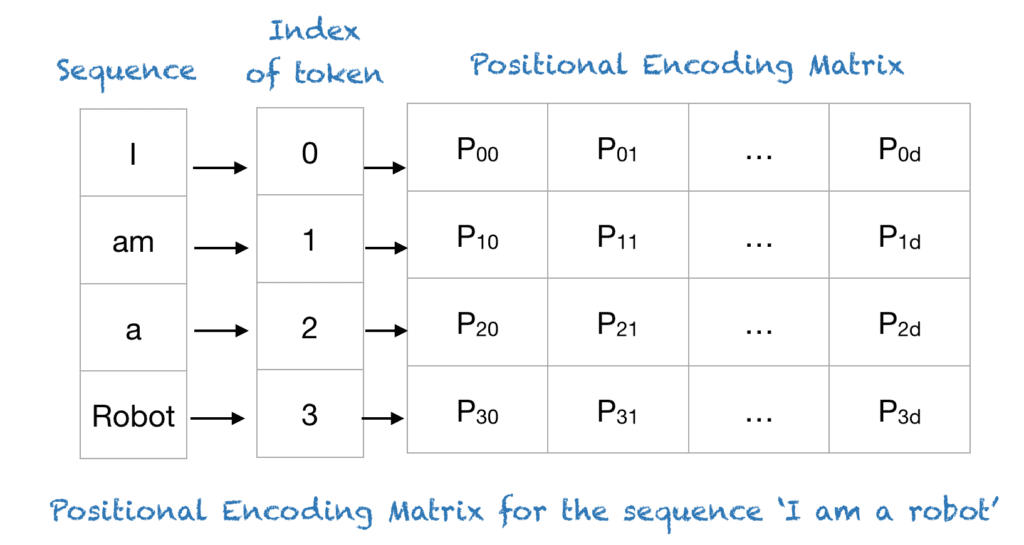


It makes use of trigonometric functions:
$$
f(t) = \sin(\lambda \cdot w \cdot t)
$$,
where $w$[rad/s] is the sinus frequency, $T = \frac{2\pi}{w}$[s] is the period and $\lambda$ the wavelength. Hence, if we have $\sin(2\cdot 2\cdot \pi\cdot t)$, it corresponds to $\lambda = 2$, $w = 2\cdot \pi$, $T = 1$s.

Now suppose we have an input sequence of length L and require the position of the k-th object within this sequence. The positional encoding is then given by the sine and cosine functions of varying frequences:

$$P(k,2i) = \sin\left(\frac{k}{n^{\frac{2i}{d}}}\right)$$
$$P(k,2i + 1) = \cos\left(\frac{k}{n^{\frac{2i}{d}}}\right)$$
where
- k: Position of an object in the input sequence: $0\leq k \leq L/2$
- Dimension of the output embedding space.
- $P(k,j)$: Position function for mapping a position $k$ in the input sequence to index $(k,j)$ of the positional matrix.
- n: User-defined scalar, set to 10000 by the authors of [Attention is all you need](https://arxiv.org/abs/1706.03762).
- i: Used for mapping to column indices $0\leq i \leq d/2$, with a single value of $i$ maps to both sine and cosine functions.

Here we have a clearer example:
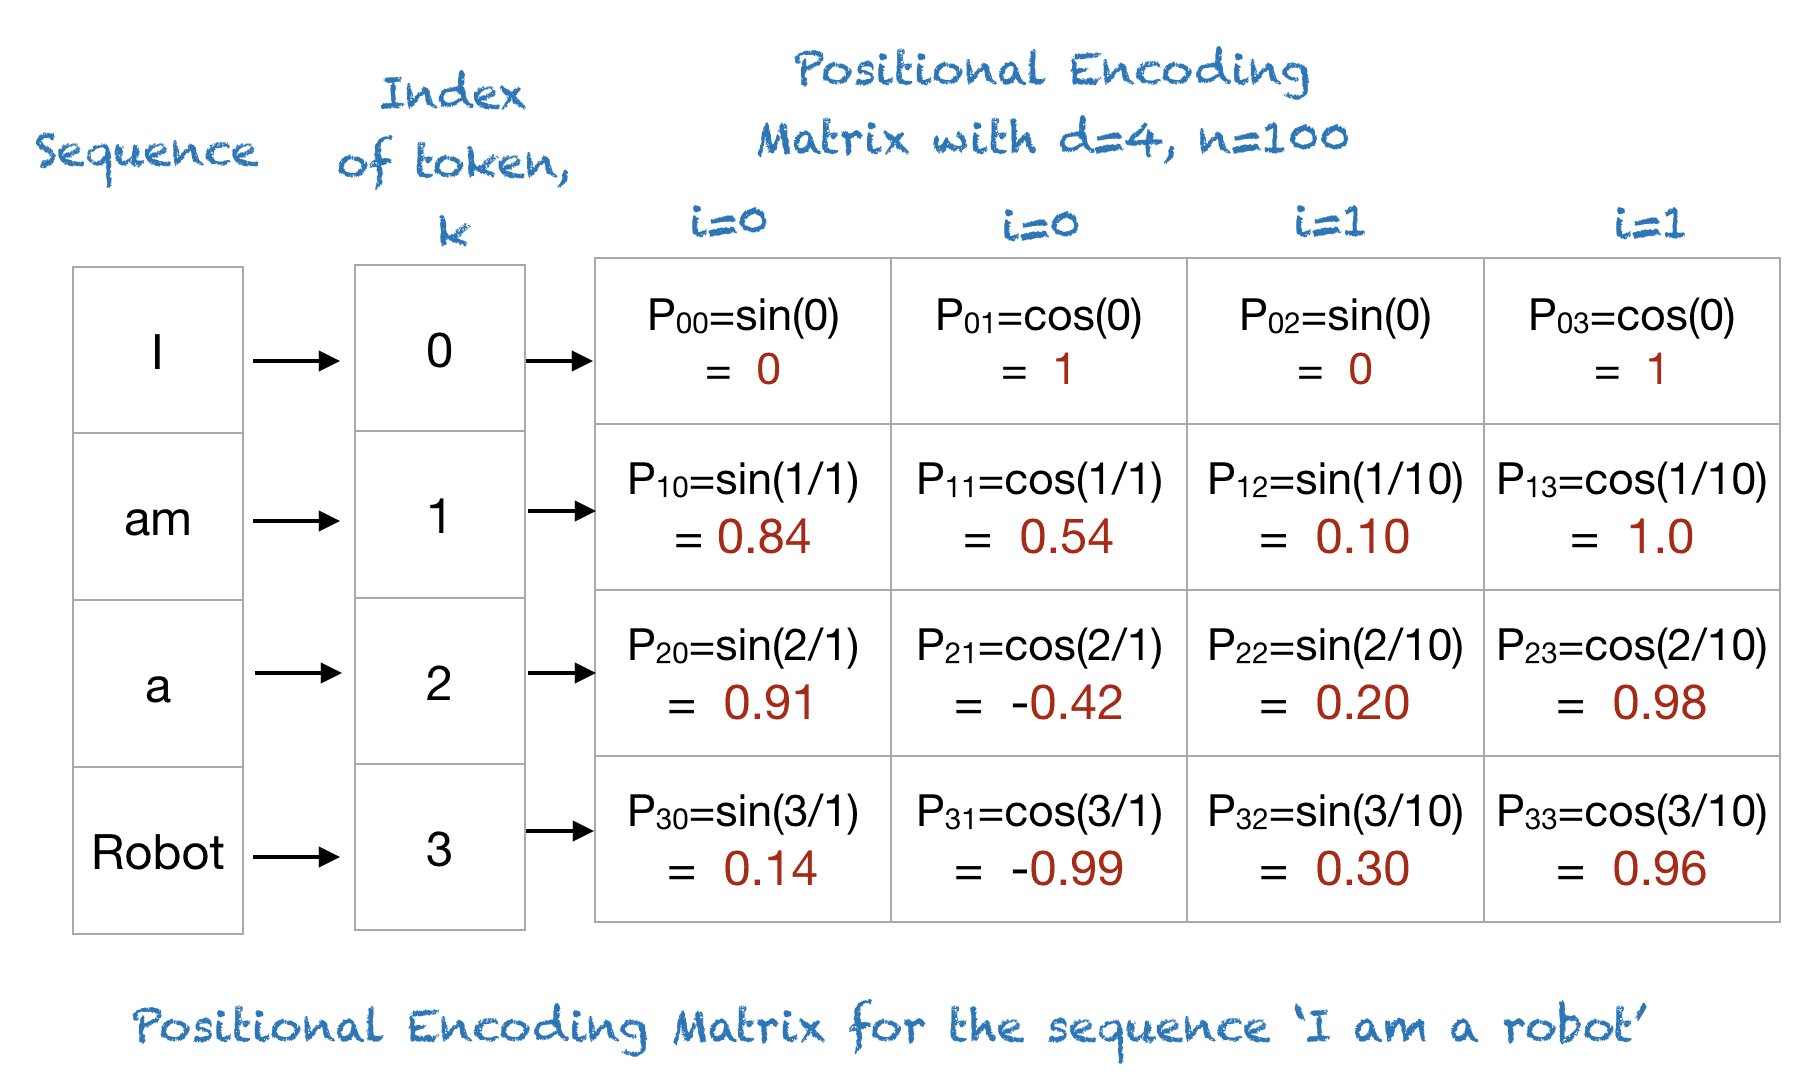


In [ ]:
x = "I am a Robot"
input1 = x.split(' ')
input2 = padded

def pos_embedding_matrix(input, d, n):

  matrix = np.zeros(shape = (d, len(input))) # Wrong!!
  matrix = np.zeros(shape = (len(input), d))

  for k in range(len(input)):
    for i in range(int(d/2)):
      matrix[k, 2*i] = np.sin(k/n**(2*i/d))
      matrix[k, 2*i + 1] = np.cos(k/n**(2*i/d))

  return matrix

"""
Solution:

import numpy as np
import matplotlib.pyplot as plt

def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

P = getPositionEncoding(seq_len=4, d=4, n=100)
print(P)
"""
d = padded.shape[0]
Matrix = pos_embedding_matrix(input2[0], d, 10000)





In [ ]:
padded

array([[ 2,  3,  4,  5,  0,  0,  0,  0,  0],
       [ 6,  7,  8,  9,  0,  0,  0,  0,  0],
       [10, 11, 12, 13, 14,  0,  0,  0,  0],
       [15, 16, 17, 18, 19, 20, 21,  0,  0]], dtype=int32)

In [ ]:
Matrix

array([[ 0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.84147098,  0.54030231,  0.00999983,  0.99995   ],
       [ 0.90929743, -0.41614684,  0.01999867,  0.99980001],
       [ 0.14112001, -0.9899925 ,  0.0299955 ,  0.99955003],
       [-0.7568025 , -0.65364362,  0.03998933,  0.99920011],
       [-0.95892427,  0.28366219,  0.04997917,  0.99875026],
       [-0.2794155 ,  0.96017029,  0.05996401,  0.99820054],
       [ 0.6569866 ,  0.75390225,  0.06994285,  0.997551  ],
       [ 0.98935825, -0.14550003,  0.07991469,  0.99680171]])

In [ ]:
print(f"Input = {input2[0]}")
print(f"Output matrix = {Matrix}")

Input = [2 3 4 5 0 0 0 0 0]
Output matrix = [[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.00999983  0.99995   ]
 [ 0.90929743 -0.41614684  0.01999867  0.99980001]
 [ 0.14112001 -0.9899925   0.0299955   0.99955003]
 [-0.7568025  -0.65364362  0.03998933  0.99920011]
 [-0.95892427  0.28366219  0.04997917  0.99875026]
 [-0.2794155   0.96017029  0.05996401  0.99820054]
 [ 0.6569866   0.75390225  0.06994285  0.997551  ]
 [ 0.98935825 -0.14550003  0.07991469  0.99680171]]


In [ ]:
obt = out_embedding
for sentence in obt:
  obt = obt + Matrix

obt

<tf.Tensor: shape=(4, 9, 4), dtype=float32, numpy=
array([[[-0.0482394 ,  4.0301948 , -0.04998225,  3.9608963 ],
        [ 3.384916  ,  2.125745  ,  0.01014697,  4.0098577 ],
        [ 3.6048603 , -1.6645212 ,  0.08930746,  3.9874907 ],
        [ 0.51552516, -3.9416304 ,  0.08949097,  3.9891984 ],
        [-3.0211794 , -2.5806918 ,  0.16120526,  3.973613  ],
        [-3.8296666 ,  1.1685313 ,  0.20116459,  3.9718137 ],
        [-1.1116313 ,  3.8745637 ,  0.24110393,  3.969615  ],
        [ 2.633977  ,  3.0494914 ,  0.2810193 ,  3.9670167 ],
        [ 3.9634635 , -0.54811764,  0.3209067 ,  3.9640198 ]],

       [[-0.00891959,  4.0379744 ,  0.03347529,  4.024857  ],
        [ 3.3777392 ,  2.1494627 , -0.00435152,  3.9598274 ],
        [ 3.6473885 , -1.6892551 ,  0.03066281,  4.047397  ],
        [ 0.5884063 , -4.000972  ,  0.14059909,  3.9483662 ],
        [-3.0211794 , -2.5806918 ,  0.16120526,  3.973613  ],
        [-3.8296666 ,  1.1685313 ,  0.20116459,  3.9718137 ],
        [-1.11163

Let us understand better what is truly happening here:


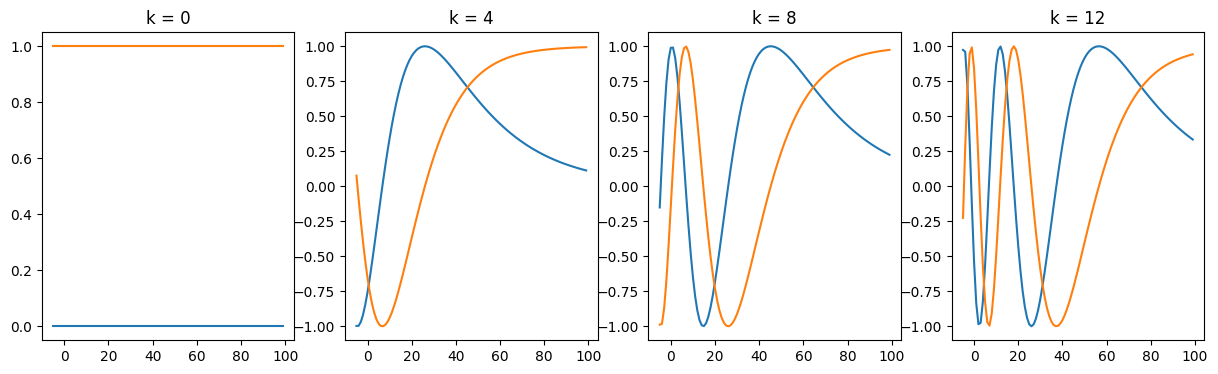

In [ ]:
def plotsinus(k, d = 512, n = 10000):
  x = np.arange(-5,100,1)
  den = np.power(n, 2*x/d)
  y_sin = np.sin(k/den)
  y_cos = np.cos(k/den)
  plt.plot(x,y_sin)
  plt.plot(x,y_cos)
  plt.title('k = ' + str(k))

fig = plt.figure(figsize = (15,4))
for i in range(4):
  plt.subplot(141 + i)
  plotsinus(i*4)

We observe that each position $k$ corresponds to a different sinusoid, which encodes a single position into a vector. We can see that the wavelength for a fixed $i$ is given by $\lambda_i = 2\cdot \pi \cdot n^{2i/d}$. Moreover, with sine and cosine functions we are kind of converting the positions into their binary counterparts, as can be seen in the following image:
\begin{align}
  0: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & &
  8: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  1: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & &
  9: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\
  2: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & &
  10: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\
  3: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & &
  11: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\
  4: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & &
  12: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  5: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & &
  13: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\
  6: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & &
  14: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\
  7: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & &
  15: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\
\end{align} %]]>

## References
1. [A Gentle Introduction to Positional Encoding in Transformer Models, Part 1](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/)
2. [Transformer Architecture: The Positional Encoding](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)
3. [How Transformers Work: A Detailed Exploration of Transformer Architecture](https://www.datacamp.com/tutorial/how-transformers-work)
4. [Visual Guide to Transformer Neural Networks - (Episode 1) Position Embeddings](https://www.youtube.com/watch?v=dichIcUZfOw)

In [ ]:
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
x = ["Hello how are you?"] # But if we use x = "Hello how are you than the tokens are letters
tokenizer = Tokenizer(num_words = 100, oov_token = "<OOV>")
tokenizer.fit_on_texts(x)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(x)
model = keras.Sequential()
model.add(keras.layers.Embedding(1000, 64))

In [ ]:
embed = keras.layers.Embedding(50_000, 3)
embed(sequences)
sequ

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 2 (of type <class 'int'>)

In [ ]:
import numpy as np
sequences = np.array(sequences)
embed(sequences)

<tf.Tensor: shape=(1, 4, 3), dtype=float32, numpy=
array([[[ 0.04415027,  0.01178475,  0.03129861],
        [ 0.02973295,  0.04911195,  0.0431701 ],
        [ 0.03017138,  0.00770153,  0.03076973],
        [-0.03575581,  0.04039863, -0.02979439]]], dtype=float32)>

In [ ]:
import torch
import math

# Parámetros del modelo
d_model = 512  # Dimensión del vector de embedding
max_len = 100  # Longitud máxima de la secuencia

pe = torch.zeros(max_len, d_model)
print("Matriz inicial de encodings posicionales (pe):\\n", pe)

position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
print("Posiciones (position):\\n", position)


div_term = torch.exp(torch.arange(0,d_model, 2).float()*(-math.log(10000.0) / d_model))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)
print("Matriz de encodings posicionales después de aplicar seno y coseno (pe):\\n", pe)

Matriz inicial de encodings posicionales (pe):\n tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Posiciones (position):\n tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.],
        [20.],
        [21.],
        [22.],
        [23.],
        [24.],
        [25.],
        [26.],
        [27.],
        [28.],
        [29.],
        [30.],
        [31.],
        [32.],
        [33.],
        [34.],
        [35.],
        [36.],
        [37.],
        [38.],
        [39.],
        [40.],
        [41.],
        [42.],
        [43.],
        [44.

In [ ]:
pe = pe.unsqueeze(0).transpose(0,1)

pe[:x.

NameError: name 'self' is not defined

# References
* [How to choose the right embedding model for your LLM applicaiton](https://medium.com/@ashutoshs81127/how-to-choose-the-right-embedding-model-for-your-llm-application-7f5b257fd389)